In [ ]:
!pip install kaggle
!pip install --upgrade efficientnet-pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=907ce7af912d6831ce417c2f0913727feb6d2391f892090ddcf5c0d379472961
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import albumentations as A
import shutil
import cv2
from efficientnet_pytorch import EfficientNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.modules.activation import ReLU
import torchvision
from torch.utils.data import DataLoader
import time
import random
from torchvision import models
from efficientnet_pytorch import EfficientNet
import torchvision.transforms as transforms
from PIL import Image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch
import PIL
import torch.nn as nn
import torchvision.models as models
from torch.nn import Linear, Sequential, Dropout

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


In [ ]:
!kaggle datasets download -d shashwatwork/fruitnet-indian-fruits-dataset-with-quality

100% 3.03G/3.03G [01:40<00:00, 40.0MB/s]
100% 3.03G/3.03G [01:40<00:00, 32.4MB/s]


In [ ]:
!unzip fruitnet-indian-fruits-dataset-with-quality.zip

Streaming output truncated to the last 5000 lines.
  inflating: Processed Images_Fruits/Good Quality_Fruits/Pomegranate_Good/20190820_151101_24507.jpg  
  inflating: Processed Images_Fruits/Good Quality_Fruits/Pomegranate_Good/20190820_151102.jpg  
  inflating: Processed Images_Fruits/Good Quality_Fruits/Pomegranate_Good/20190820_151102_24508.jpg  
  inflating: Processed Images_Fruits/Good Quality_Fruits/Pomegranate_Good/20190820_151102_24509.jpg  
  inflating: Processed Images_Fruits/Good Quality_Fruits/Pomegranate_Good/20190820_151102_24510.jpg  
  inflating: Processed Images_Fruits/Good Quality_Fruits/Pomegranate_Good/20190820_151102_24511.jpg  
  inflating: Processed Images_Fruits/Good Quality_Fruits/Pomegranate_Good/20190820_151103.jpg  
  inflating: Processed Images_Fruits/Good Quality_Fruits/Pomegranate_Good/20190820_151103_24512.jpg  
  inflating: Processed Images_Fruits/Good Quality_Fruits/Pomegranate_Good/20190820_151103_24513.jpg  
  inflating: Processed Images_Fruits/Good Q

In [ ]:
bad_fruit_data_path='/content/Processed Images_Fruits/Bad Quality_Fruits'
good_fruit_data_path='/content/Processed Images_Fruits/Good Quality_Fruits'
mixed_fruit_data_path='/content/Processed Images_Fruits/Mixed Qualit_Fruits'


filepath=[]
label=[]
ht=0
wt=0
sample=0
sample_count=20


for quality in [good_fruit_data_path, bad_fruit_data_path, mixed_fruit_data_path]:
  fruit_list_name=os.listdir(quality)
  for fruit in fruit_list_name:
    fruit_list=os.path.join(quality,fruit)
    img_list=os.listdir(fruit_list)
    for i, img in enumerate(img_list):
      img_path=os.path.join(fruit_list, img)
      if i< sample_count:
        img=plt.imread(img_path) #this is reading the image and returning an numpy array.
        ht+=img.shape[0]
        wt+=img.shape[1]
        sample+=1
      filepath.append(img_path)
      if quality==mixed_fruit_data_path:
        label.append(fruit+'_mixed')
      else:
        label.append(fruit)
F_DATA=pd.Series(filepath,name='filepaths')
L_DATA=pd.Series(label,name='labels')
fruit_quality_data_final=pd.concat([F_DATA, L_DATA], axis=1)
fruit_quality_data_final

filepaths        labels
0      /content/Processed Images_Fruits/Good Quality_...     Lime_Good
1      /content/Processed Images_Fruits/Good Quality_...     Lime_Good
2      /content/Processed Images_Fruits/Good Quality_...     Lime_Good
3      /content/Processed Images_Fruits/Good Quality_...     Lime_Good
4      /content/Processed Images_Fruits/Good Quality_...     Lime_Good
...                                                  ...           ...
19521  /content/Processed Images_Fruits/Mixed Qualit_...  Banana_mixed
19522  /content/Processed Images_Fruits/Mixed Qualit_...  Banana_mixed
19523  /content/Processed Images_Fruits/Mixed Qualit_...  Banana_mixed
19524  /content/Processed Images_Fruits/Mixed Qualit_...  Banana_mixed
19525  /content/Processed Images_Fruits/Mixed Qualit_...  Banana_mixed

[19526 rows x 2 columns]

In [ ]:
fruit_quality_data_final['labels'].value_counts()

Pomegranate_Good     5940
Orange_Good          1216
Pomegranate_Bad      1187
Orange_Bad           1159
Guava_Good           1152
Apple_Good           1149
Apple_Bad            1141
Guava_Bad            1129
Banana_Good          1113
Lime_Good            1094
Banana_Bad           1087
Lime_Bad             1085
Banana_mixed          285
Lemon_mixed           278
Guava_mixed           148
Orange_mixed          125
Pomegranate_mixed     125
Apple_mixed           113
Name: labels, dtype: int64

In [ ]:
good_label_list=['Pomegranate_Good', 'Orange_Good', 'Guava_Good', 'Apple_Good', 'Banana_Good', 'Lime_Good']
good_count = (fruit_quality_data_final['labels'].isin(good_label_list)).sum()
print('GOOD FRUITS:',good_count)

bad_label_list=['Pomegranate_Bad', 'Orange_Bad', 'Guava_Bad', 'Apple_Bad', 'Banana_Bad', 'Lime_Bad']
bad_count = (fruit_quality_data_final['labels'].isin(bad_label_list)).sum()
print('BAD FRUITS:',bad_count)

mixed_label_list=['Pomegranate_mixed', 'Orange_mixed', 'Guava_mixed', 'Apple_mixed', 'Banana_mixed', 'Lime_mixed']
mixed_count = (fruit_quality_data_final['labels'].isin(mixed_label_list)).sum()
print('MIXED FRUITS:',mixed_count)

GOOD FRUITS: 11664
BAD FRUITS: 6788
MIXED FRUITS: 796


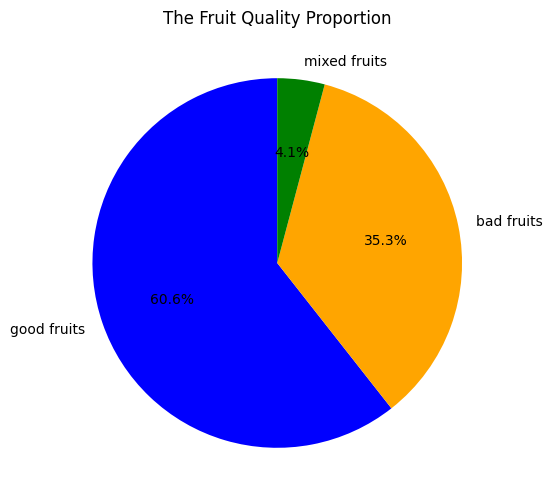

In [ ]:
values_pie=[good_count, bad_count, mixed_count]
labels_pie=['good fruits', 'bad fruits', 'mixed fruits']
plt.figure(figsize=(6,6))
plt.pie(values_pie, labels=labels_pie, autopct='%1.1f%%', startangle=90, colors=['blue', 'orange', 'green'])
plt.title("The Fruit Quality Proportion")
plt.show()

In [ ]:
def trim(max_size):

  print("the original elements are:",fruit_quality_data_final['labels'].nunique())
  count=0
  #first grouping the categories from the dataframe by means of labels then using lambda fucntion and wih the expression
  #then using sample we are sampling each group and considering it as x check if they have length >200 if not nothing to sample
  groups=fruit_quality_data_final.groupby('labels').apply(lambda x:x.sample(max_size,replace=False) if len(x)>max_size else x)
  trimmed_fruit= groups.reset_index(drop=True)
  print(list(trimmed_fruit['labels'].value_counts()))
  return trimmed_fruit

trimmed_fruit=trim(500)
trimmed_fruit

the original elements are: 18
[500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 285, 278, 148, 125, 125, 113]


filepaths             labels
0     /content/Processed Images_Fruits/Bad Quality_F...          Apple_Bad
1     /content/Processed Images_Fruits/Bad Quality_F...          Apple_Bad
2     /content/Processed Images_Fruits/Bad Quality_F...          Apple_Bad
3     /content/Processed Images_Fruits/Bad Quality_F...          Apple_Bad
4     /content/Processed Images_Fruits/Bad Quality_F...          Apple_Bad
...                                                 ...                ...
7069  /content/Processed Images_Fruits/Mixed Qualit_...  Pomegranate_mixed
7070  /content/Processed Images_Fruits/Mixed Qualit_...  Pomegranate_mixed
7071  /content/Processed Images_Fruits/Mixed Qualit_...  Pomegranate_mixed
7072  /content/Processed Images_Fruits/Mixed Qualit_...  Pomegranate_mixed
7073  /content/Processed Images_Fruits/Mixed Qualit_...  Pomegranate_mixed

[7074 rows x 2 columns]

In [ ]:
def image_augmentation(group, target_dir, augmentation_sequence):
    count = 0
    augmented_data = []
    for i, row in group.iterrows():
        image_path = row['filepaths']
        image = cv2.imread(image_path)
        grp_length = len(group)
        num_image = 500 - grp_length
        while count < num_image:
            augmentation = augmentation_sequence(image=image)
            augmented_image = augmentation['image']
            count += 1
            augmented_data.append({
                'filepaths': os.path.join(target_dir, f'aug-{i}-{count}.jpg'),
                'labels': row['labels']
            })
            cv2.imwrite(augmented_data[-1]['filepaths'], augmented_image)

    return pd.DataFrame(augmented_data)


def balance(max_size, trimmed):
    num_image = 0
    label_count = trimmed['labels'].value_counts()
    merged_dataset=[]
    if (label_count < max_size).any():
        underrepresented_categories = label_count[label_count < max_size].index
        trimmed = trimmed[trimmed['labels'].isin(underrepresented_categories)].copy()

        aug_dir = os.path.join(r'./', 'aug')
        if os.path.isdir(aug_dir):
            shutil.rmtree(aug_dir)
        os.mkdir(aug_dir)

        for label in trimmed['labels'].unique():
            dir_path = os.path.join(aug_dir, label)
            os.mkdir(dir_path)

        augmented_image = A.Compose([
            A.HorizontalFlip(p=0.8),
            A.RandomBrightnessContrast(p=0.7),
            A.VerticalFlip(p=0.6),
            A.RGBShift(r_shift_limit=30, g_shift_limit = 20, b_shift_limit=20, p= 0.5),
            A.ZoomBlur(p=0.3)
        ])
        groups = trimmed.groupby('labels')

        for label in trimmed['labels'].unique():
            group = groups.get_group(label)
            target_dir = os.path.join(aug_dir, label)
            merged_dataset.append(image_augmentation(group, target_dir, augmented_image))

        original_aug = pd.concat([trimmed] + merged_dataset, ignore_index=True)

    return original_aug

balance=balance(500, trimmed_fruit)
balance

filepaths             labels
0     /content/Processed Images_Fruits/Mixed Qualit_...        Apple_mixed
1     /content/Processed Images_Fruits/Mixed Qualit_...        Apple_mixed
2     /content/Processed Images_Fruits/Mixed Qualit_...        Apple_mixed
3     /content/Processed Images_Fruits/Mixed Qualit_...        Apple_mixed
4     /content/Processed Images_Fruits/Mixed Qualit_...        Apple_mixed
...                                                 ...                ...
2995           ./aug/Pomegranate_mixed/aug-6949-371.jpg  Pomegranate_mixed
2996           ./aug/Pomegranate_mixed/aug-6949-372.jpg  Pomegranate_mixed
2997           ./aug/Pomegranate_mixed/aug-6949-373.jpg  Pomegranate_mixed
2998           ./aug/Pomegranate_mixed/aug-6949-374.jpg  Pomegranate_mixed
2999           ./aug/Pomegranate_mixed/aug-6949-375.jpg  Pomegranate_mixed

[3000 rows x 2 columns]

In [ ]:
balance['labels'].value_counts()

Apple_mixed          500
Banana_mixed         500
Guava_mixed          500
Lemon_mixed          500
Orange_mixed         500
Pomegranate_mixed    500
Name: labels, dtype: int64

In [ ]:
def trim_diff(max_size, trimmed):
    label_count = trimmed['labels'].value_counts()
    trimmed_diff = pd.DataFrame()
    if (label_count== max_size).any():
        underrepresented_categories = label_count[label_count== max_size].index
        trimmed_diff = trimmed[trimmed['labels'].isin(underrepresented_categories)].copy()
    return trimmed_diff

trim=trim_diff(500, trimmed_fruit)
trim

filepaths            labels
0     /content/Processed Images_Fruits/Bad Quality_F...         Apple_Bad
1     /content/Processed Images_Fruits/Bad Quality_F...         Apple_Bad
2     /content/Processed Images_Fruits/Bad Quality_F...         Apple_Bad
3     /content/Processed Images_Fruits/Bad Quality_F...         Apple_Bad
4     /content/Processed Images_Fruits/Bad Quality_F...         Apple_Bad
...                                                 ...               ...
6944  /content/Processed Images_Fruits/Good Quality_...  Pomegranate_Good
6945  /content/Processed Images_Fruits/Good Quality_...  Pomegranate_Good
6946  /content/Processed Images_Fruits/Good Quality_...  Pomegranate_Good
6947  /content/Processed Images_Fruits/Good Quality_...  Pomegranate_Good
6948  /content/Processed Images_Fruits/Good Quality_...  Pomegranate_Good

[6000 rows x 2 columns]

In [ ]:
Fruit_Data=pd.concat([trim, balance])
Fruit_Data

filepaths             labels
0     /content/Processed Images_Fruits/Bad Quality_F...          Apple_Bad
1     /content/Processed Images_Fruits/Bad Quality_F...          Apple_Bad
2     /content/Processed Images_Fruits/Bad Quality_F...          Apple_Bad
3     /content/Processed Images_Fruits/Bad Quality_F...          Apple_Bad
4     /content/Processed Images_Fruits/Bad Quality_F...          Apple_Bad
...                                                 ...                ...
2995           ./aug/Pomegranate_mixed/aug-6949-371.jpg  Pomegranate_mixed
2996           ./aug/Pomegranate_mixed/aug-6949-372.jpg  Pomegranate_mixed
2997           ./aug/Pomegranate_mixed/aug-6949-373.jpg  Pomegranate_mixed
2998           ./aug/Pomegranate_mixed/aug-6949-374.jpg  Pomegranate_mixed
2999           ./aug/Pomegranate_mixed/aug-6949-375.jpg  Pomegranate_mixed

[9000 rows x 2 columns]

In [ ]:
print(list(Fruit_Data['labels'].value_counts()))

[500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500]


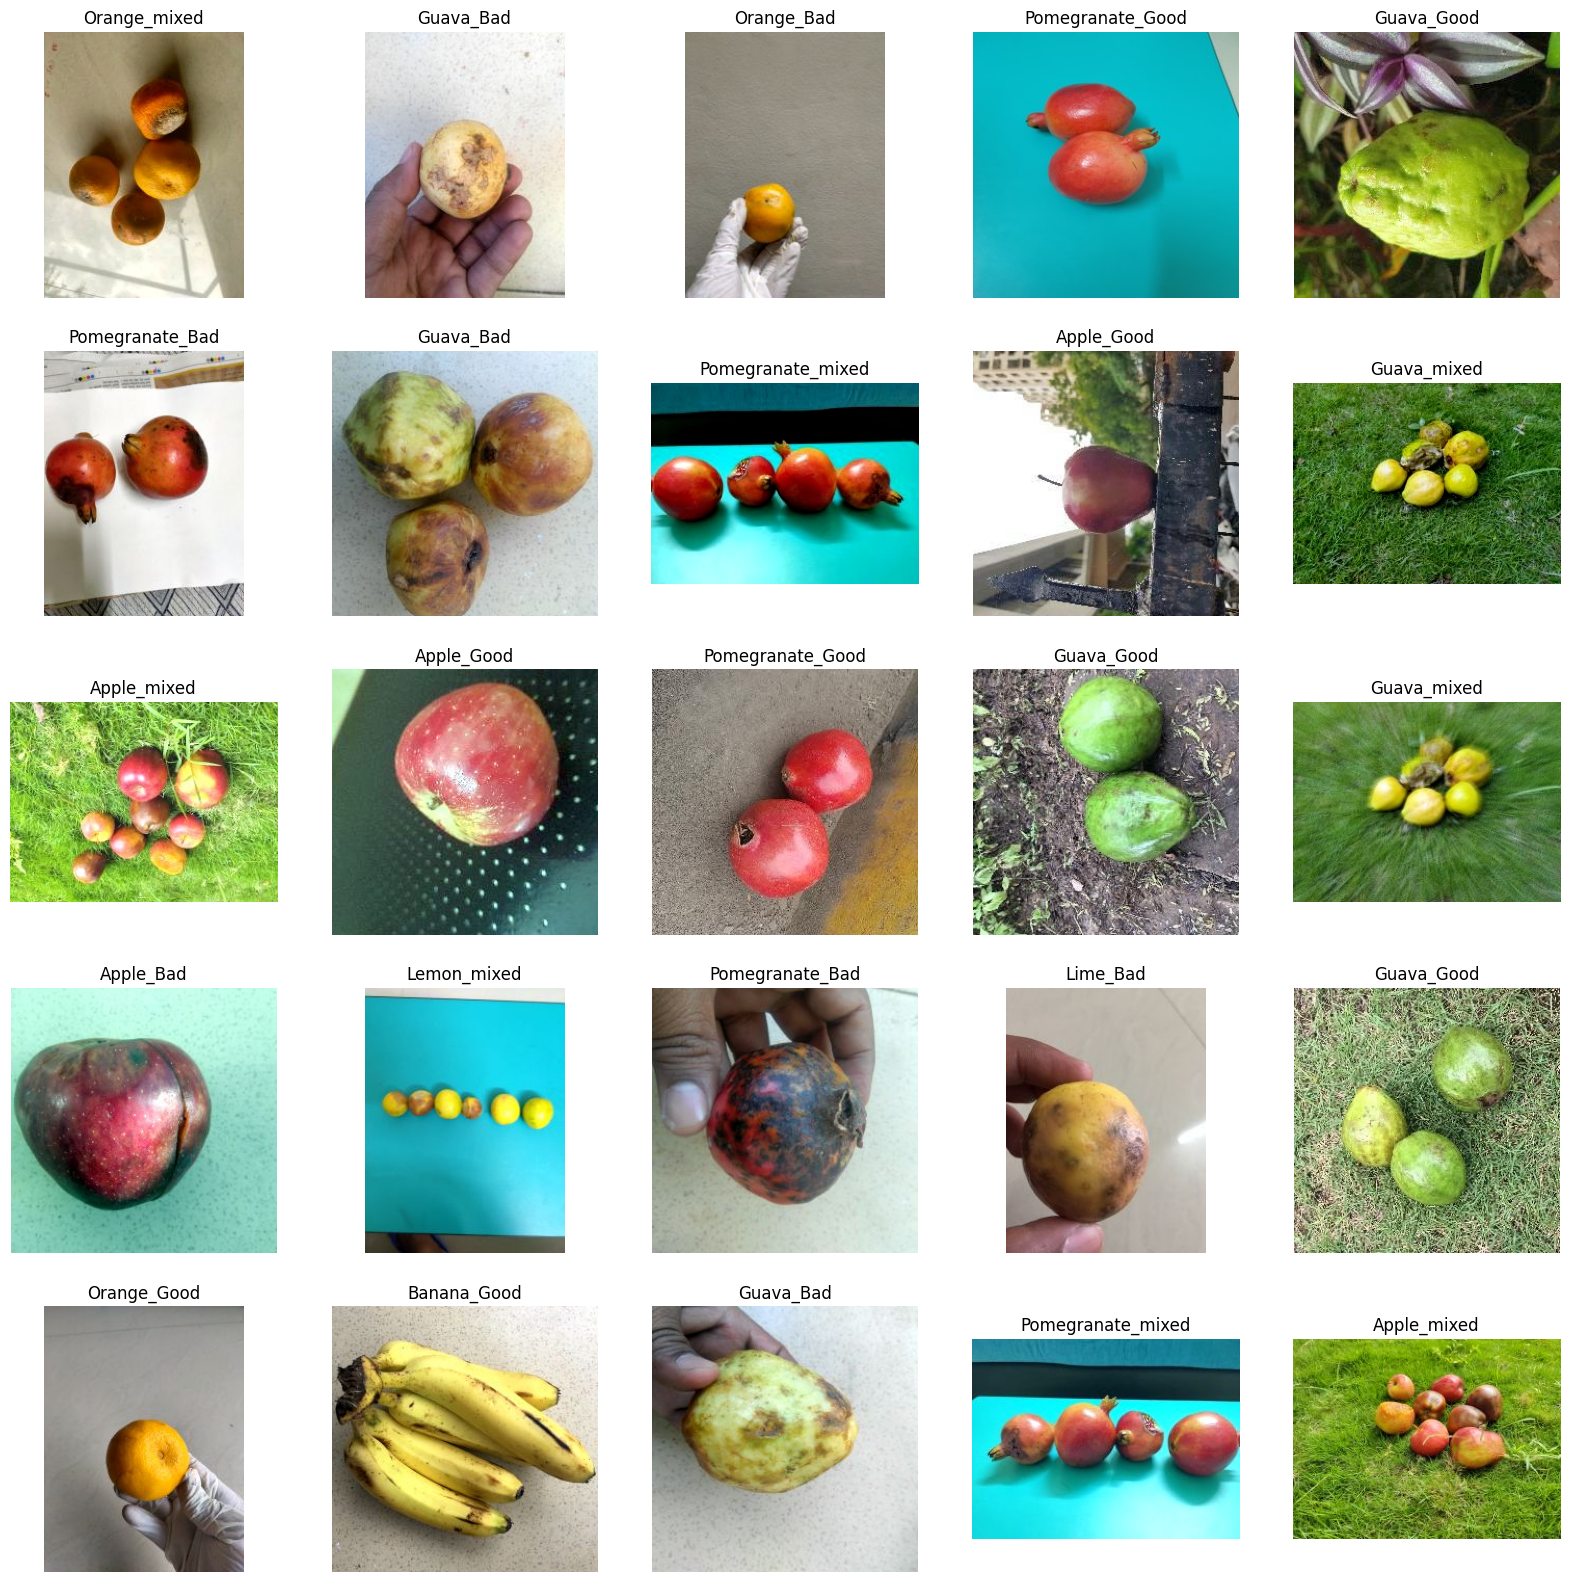

In [ ]:
def image_show(gen):
    plt.figure(figsize=(20, 20))
    if len(gen) > 25:
        r = 25
    else:
        r = len(gen)
    random_sample = random.sample(range(len(gen)), r)

    for i, idx in enumerate(random_sample):
        image_path = gen.iloc[idx, 0]
        label = gen.iloc[idx, 1]
        image = Image.open(image_path)
        plt.subplot(5, 5, i + 1)
        plt.imshow(image)
        plt.title(label)
        plt.axis('off')  # Turn off axis for cleaner visualization

    plt.show()

image_show(Fruit_Data)


In [ ]:
train_mean =[0.55800074, 0.58500165, 0.51459914]
train_std =[0.2085998, 0.21319997, 0.2374757 ]

In [ ]:
train_set, temp_set = train_test_split(Fruit_Data, test_size=0.35, random_state=42)
val_set, test_set = train_test_split(temp_set, test_size=0.5, random_state=42)
len(train_set), len(test_set), len(val_set)

(5850, 1575, 1575)

In [ ]:
# Class information
unique_labels = train_set['labels'].unique()
num_classes = len(unique_labels)
class_to_index = {label: idx for idx, label in enumerate(unique_labels)}

print("Class to Index Mapping:")
print(class_to_index)

# Define custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['filepaths']
        label = self.dataframe.iloc[idx]['labels']
        numerical_label = class_to_index[label]  # Convert label to numerical representation
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, numerical_label


# Define transformations
img_size = (256, 256)
train_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0, hue=0),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor()
])

# Create custom datasets
train_dataset = CustomDataset(train_set, transform=train_transform)
valid_dataset = CustomDataset(val_set, transform=test_transform)
test_dataset = CustomDataset(test_set, transform=test_transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Get class information
# Print class information
print('Number of classes:', len(unique_labels))
print('{0:^25s}{1:^12s}'.format('class name', 'class index'))
for class_label, idx in class_to_index.items():
    print(f'{class_label:^25s}{str(idx):^12s}')


Class to Index Mapping:
{'Apple_Bad': 0, 'Guava_Bad': 1, 'Apple_Good': 2, 'Banana_Bad': 3, 'Lime_Good': 4, 'Orange_Bad': 5, 'Banana_Good': 6, 'Pomegranate_Bad': 7, 'Guava_mixed': 8, 'Apple_mixed': 9, 'Lemon_mixed': 10, 'Banana_mixed': 11, 'Guava_Good': 12, 'Lime_Bad': 13, 'Pomegranate_Good': 14, 'Pomegranate_mixed': 15, 'Orange_mixed': 16, 'Orange_Good': 17}
Number of classes: 18
       class name        class index 
        Apple_Bad             0      
        Guava_Bad             1      
       Apple_Good             2      
       Banana_Bad             3      
        Lime_Good             4      
       Orange_Bad             5      
       Banana_Good            6      
     Pomegranate_Bad          7      
       Guava_mixed            8      
       Apple_mixed            9      
       Lemon_mixed            10     
      Banana_mixed            11     
       Guava_Good             12     
        Lime_Bad              13     
    Pomegranate_Good          14     
    Pomeg

In [ ]:
d=5
for i, j in enumerate(train_loader):
    image, label = j  # Access elements of the tuple

    print(image.shape)  # Shape of the image tensor
    print(len(label))  # Shape of the label tensor

    # Optionally break the loop after a certain number of iterations
    d -= 1
    if d <= 2:
        break


torch.Size([32, 3, 256, 256])
32
torch.Size([32, 3, 256, 256])
32
torch.Size([32, 3, 256, 256])
32


In [ ]:
print('Image: ',train_dataset[90][0])
print('Label: ',train_dataset[90][1])


Image:  tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Label:  12


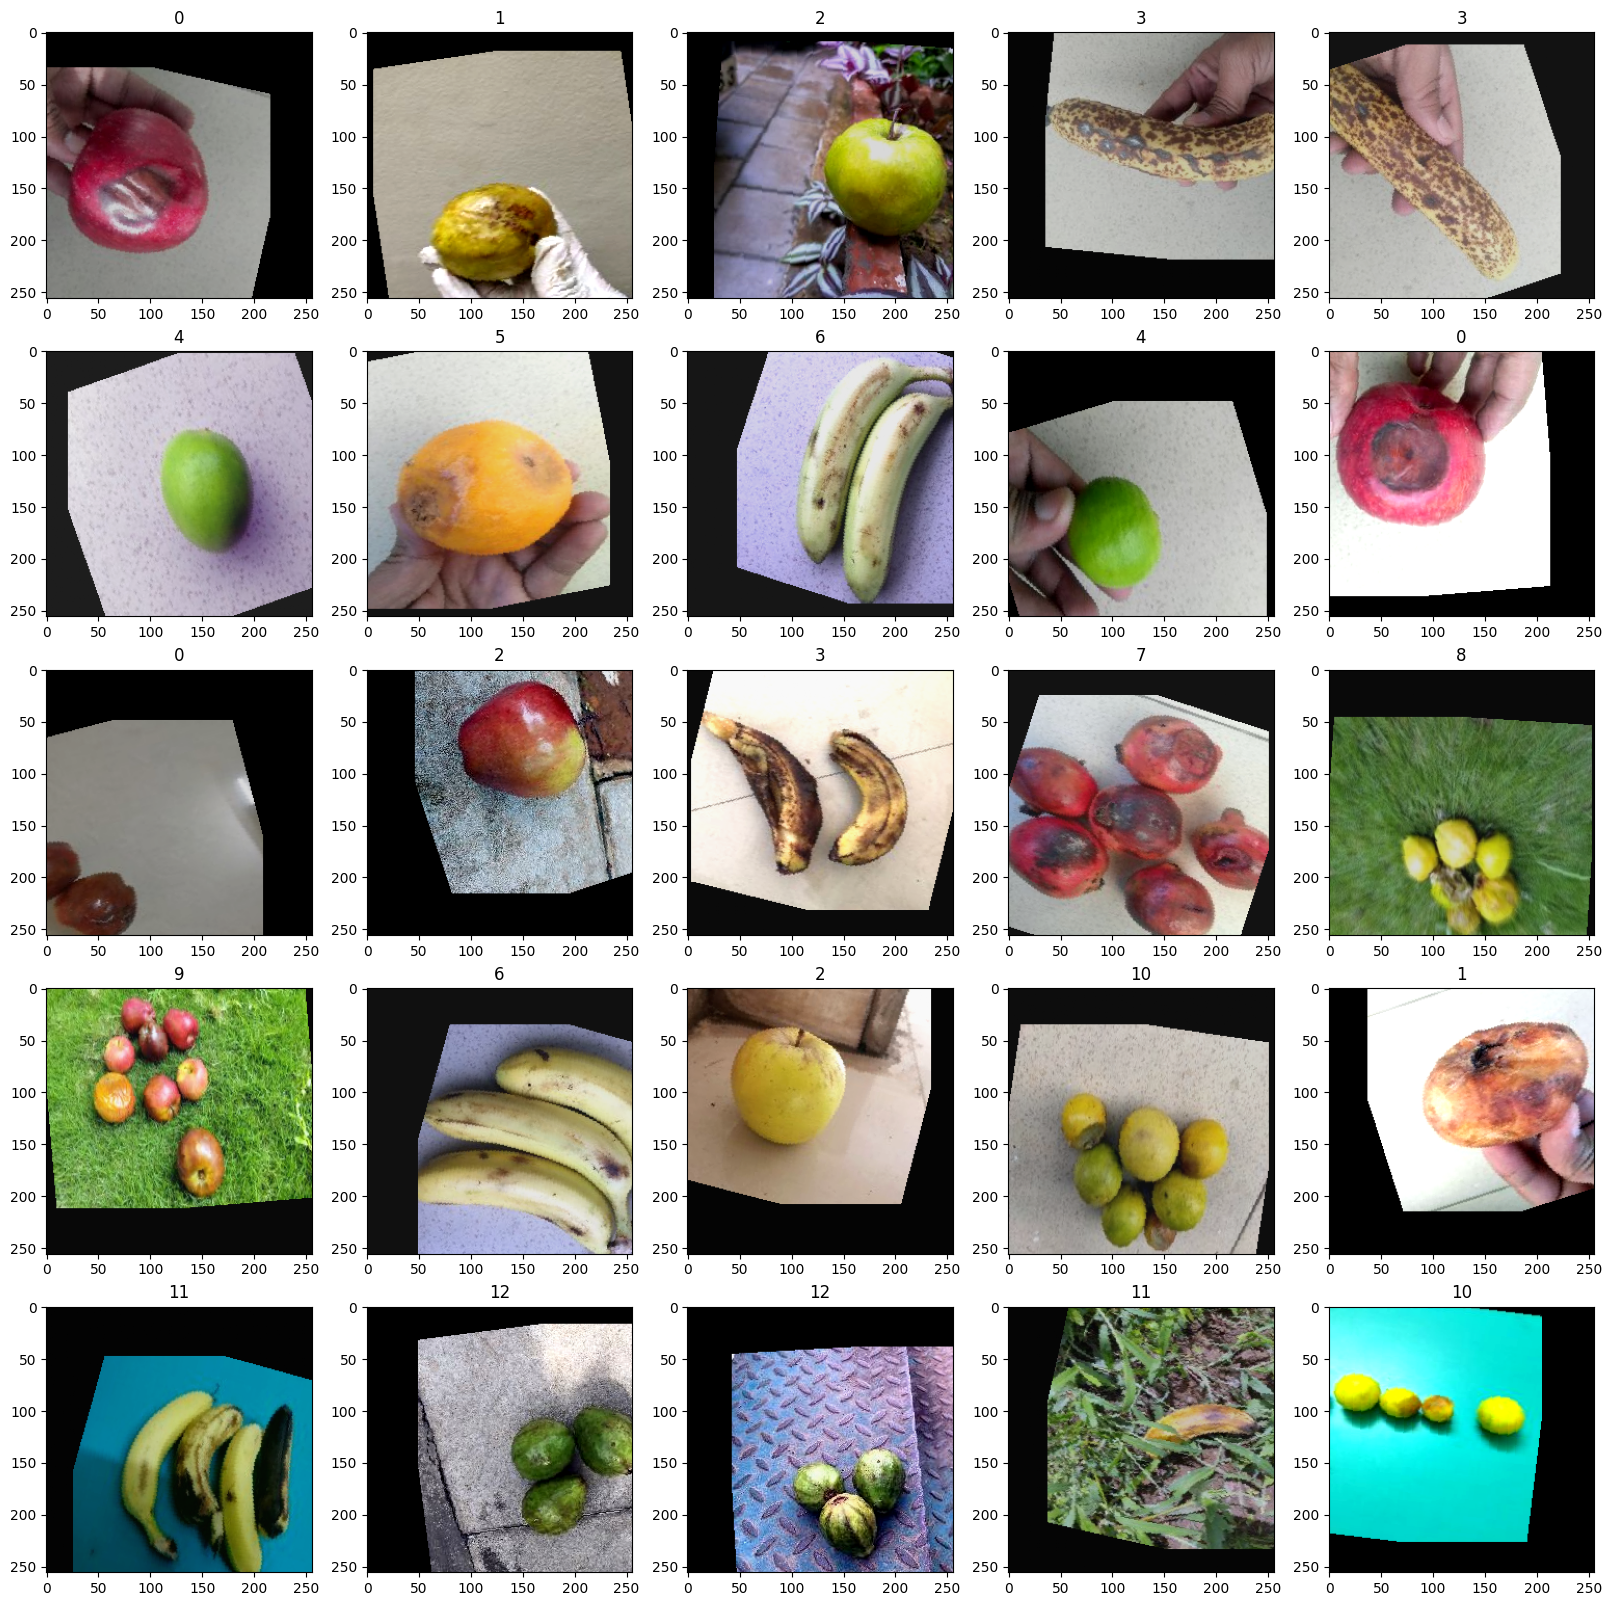

In [ ]:
def image_show_transform(gen):
    i=0
    plt.figure(figsize=(20, 20))
    i=0
    if len(gen)>25:
      r=25
    else:
      r=25

    for img_show in range(r):
      image,label=gen[i]
      image=image.permute(1, 2, 0)
      image=image.numpy()
      image = image.clip(0, 1)
      plt.subplot(5, 5, i+1)
      plt.imshow(image)
      plt.title(label)
      i+=1
    plt.show()
image_show_transform(train_dataset)

## TRAINING VALIDATION AND TESTING SETS

In [ ]:

def train(model, iterator, optimizer, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  # Train mode
  model.train()

  for (x,y) in iterator:
    x = x.to(device)
    y = y.to(device)
    # Set gradients to zero
    optimizer.zero_grad()

    # Make Predictions
    y_pred = model(x)

    # Compute loss
    loss = criterion(y_pred, y)

    # Compute accuracy
    acc = calculate_accuracy(y_pred, y)

    # Backprop
    loss.backward()

    # Apply optimizer
    optimizer.step()

    # Extract data from loss and accuracy
    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss/len(iterator), epoch_acc/len(iterator)


In [ ]:

def calculate_accuracy(y_pred, y):
    '''
    Compute accuracy from ground-truth and predicted labels.

    Input
    ------
    y_pred: torch.Tensor [BATCH_SIZE, N_LABELS]
    y: torch.Tensor [BATCH_SIZE]

    Output
    ------
    acc: float
        Accuracy
    '''
    y_prob = F.softmax(y_pred, dim=-1)
    y_pred = y_pred.argmax(dim=1, keepdim=True)
    if isinstance(y, tuple):
        y = y[0]  # Assuming the first element of the tuple contains the label tensor
    correct = y_pred.eq(y.view_as(y_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc


In [ ]:

def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  # Evaluation mode
  model.eval()

  # Do not compute gradients
  with torch.no_grad():

    for(x,y) in iterator:

      x = x.to(device)
      y = y.to(device)

      # Make Predictions
      y_pred = model(x)

      # Compute loss
      loss = criterion(y_pred, y)  # Corrected here

      # Compute accuracy
      acc = calculate_accuracy(y_pred, y)

      # Extract data from loss and accuracy
      epoch_loss += loss.item()
      epoch_acc += acc.item()

  return epoch_loss/len(iterator), epoch_acc/len(iterator)


In [ ]:
import torch.optim as optim

def model_training_with_ask(num_epochs, model, train_loader, val_loader, optimizer, criterion, device, checkpoint_path):
    ask_callback = ASK(model, num_epochs, ask_epoch=2)  # Initialize ASK callback
    ask_callback.on_train_begin()  # Call on_train_begin method

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the parameter gradients

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_predictions / total_predictions

        # Validation
        model.eval()  # Set model to evaluation mode
        val_running_loss = 0.0
        val_correct_predictions = 0
        val_total_predictions = 0

        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                val_running_loss += val_loss.item()

                _, val_predicted = torch.max(val_outputs, 1)
                val_total_predictions += val_labels.size(0)
                val_correct_predictions += (val_predicted == val_labels).sum().item()

        val_loss = val_running_loss / len(val_loader)
        val_accuracy = val_correct_predictions / val_total_predictions

        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Accuracy: {val_accuracy:.4f}")

        ask_callback.on_epoch_end(epoch)  # Call on_epoch_end method

        if ask_callback.ask:
            continue_training = input("\nContinue training? (yes/no): ")
            if continue_training.lower() == 'no':
                print("Training halted.")
                break
            elif continue_training.lower() == 'yes':
                pass

    ask_callback.on_train_end()  # Call on_train_end method


In [ ]:
class ASK:
    def __init__(self, model, epochs, ask_epoch):
        self.model = model
        self.ask_epoch = ask_epoch
        self.epochs = epochs
        self.ask = True

    def on_train_begin(self):
        if self.ask_epoch == 0:
            print('you set ask_epoch = 0, ask_epoch will be set to 1')
            self.ask_epoch = 1
        if self.ask_epoch >= self.epochs:
            print('ask_epoch >= epochs, will train for', self.epochs, 'epochs')
            self.ask = False
        if self.epochs == 1:
            self.ask = False
        else:
            print('Training will proceed until epoch', self.ask_epoch, 'then you will be asked to')
            print('enter H to halt training or enter an integer for how many more epochs to run then be asked again')
        self.start_time = time.time()

    def on_train_end(self):
        tr_duration = time.time() - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {int(hours)} hours, {int(minutes):d} minutes, {seconds:.2f} seconds)'
        print(msg)

    def on_epoch_end(self, epoch):
        if self.ask:
            if epoch + 1 == self.ask_epoch:
                print('\nEnter H to end training or an integer for the number of additional epochs to run then ask again')
                ans = input()

                if ans.lower() == 'h' or ans == '0':
                    print('you entered', ans, 'Training halted on epoch', epoch + 1, 'due to user input')
                    self.model.stop_training = True
                else:
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs as', self.epochs, 'cannot train for', self.ask_epoch)
                    else:
                        print('you entered', ans, 'Training will continue to epoch', self.ask_epoch)


## MODELS

### CUSTOM CNN AND AS A STUDENT

In [ ]:
#can also act as student
class CustomCNN(nn.Module):
  def __init__(self, output_dim):
    super().__init__()

    self.features = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=1),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )

    self.linear = nn.Sequential(
        nn.Linear(64 * 64 * 16, 120),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, output_dim)
    )

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.shape[0], -1)
    x = self.linear(x)

    return x

model_CNN =CustomCNN(len(unique_labels))
model_CNN

CustomCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Linear(in_features=65536, out_features=120, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): ReLU()
    (5): Linear(in_features=84, out_features=18, bias=True)
  )
)

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_CNN = model_CNN.to(device)
#parameters
def count_parameters(model_CNN):
  return sum(p.numel() for p in model_CNN.parameters() if p.requires_grad)
print(f"The model has {count_parameters(model_CNN):,} trainable parameters.")
#Loss
criterion=nn.CrossEntropyLoss()
criterion=criterion.to(device)
#Regularizer
l2_lambda = 0.016
l1_lambda = 0.006
#optim
optimizer = optim.Adamax(model_CNN.parameters(), lr=1e-4, weight_decay=l2_lambda)

The model has 7,922,790 trainable parameters.


In [ ]:
# Training
N_EPOCHS = 10
model_training_with_ask(N_EPOCHS, model_CNN, train_loader, val_loader, optimizer, criterion, device, 'lenet.pt')

Training will proceed until epoch 2 then you will be asked to
enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch [1/10], Train Loss: 2.8572, Train Accuracy: 0.0846, Val Loss: 2.7513, Val Accuracy: 0.1702

Continue training? (yes/no): yes
Epoch [2/10], Train Loss: 2.6859, Train Accuracy: 0.1750, Val Loss: 2.4964, Val Accuracy: 0.2578

Enter H to end training or an integer for the number of additional epochs to run then ask again
3
you entered 3 Training will continue to epoch 5

Continue training? (yes/no): yes
Epoch [3/10], Train Loss: 2.4965, Train Accuracy: 0.2340, Val Loss: 2.3197, Val Accuracy: 0.2692

Continue training? (yes/no): yes
Epoch [4/10], Train Loss: 2.3607, Train Accuracy: 0.2848, Val Loss: 2.1519, Val Accuracy: 0.3327

Continue training? (yes/no): yes
Epoch [5/10], Train Loss: 2.2307, Train Accuracy: 0.3174, Val Loss: 1.9740, Val Accuracy: 0.3810

Enter H to end training or an integer for the number of additional epoch

['Apple_Bad', 'Guava_Bad', 'Apple_Good', 'Banana_Bad', 'Lime_Good', 'Orange_Bad', 'Banana_Good', 'Pomegranate_Bad', 'Guava_mixed', 'Apple_mixed', 'Lemon_mixed', 'Banana_mixed', 'Guava_Good', 'Lime_Bad', 'Pomegranate_Good', 'Pomegranate_mixed', 'Orange_mixed', 'Orange_Good']
Accuracy: 46.29%


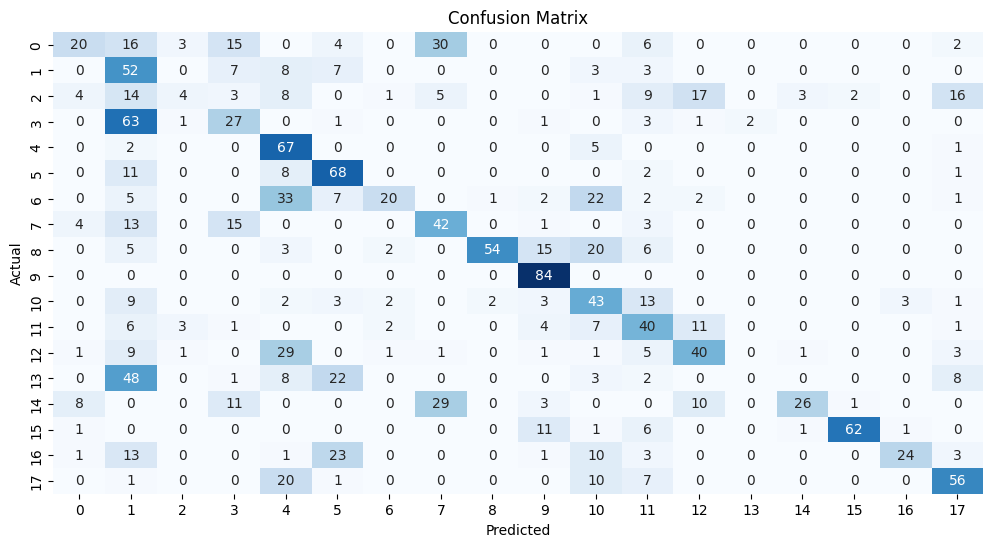

Classification Report:
----------------------
                    precision    recall  f1-score   support

        Apple_Bad     0.5128    0.2083    0.2963        96
        Guava_Bad     0.1948    0.6500    0.2997        80
       Apple_Good     0.3333    0.0460    0.0808        87
       Banana_Bad     0.3375    0.2727    0.3017        99
        Lime_Good     0.3583    0.8933    0.5115        75
       Orange_Bad     0.5000    0.7556    0.6018        90
      Banana_Good     0.7143    0.2105    0.3252        95
  Pomegranate_Bad     0.3925    0.5385    0.4541        78
      Guava_mixed     0.9474    0.5143    0.6667       105
      Apple_mixed     0.6667    1.0000    0.8000        84
      Lemon_mixed     0.3413    0.5309    0.4155        81
     Banana_mixed     0.3636    0.5333    0.4324        75
       Guava_Good     0.4938    0.4301    0.4598        93
         Lime_Bad     0.0000    0.0000    0.0000        92
 Pomegranate_Good     0.8387    0.2955    0.4370        88
Pomegran

In [ ]:
classes=list(train_set['labels'].unique())
print(classes)
# Put the model in evaluation mode
model_CNN.eval()

# Initialize lists to store true labels and predicted labels
y_true = []
y_pred = []

# Disable gradient computation for inference
with torch.no_grad():
    for inputs, labels in test_loader:  # Assuming you have defined the test DataLoader
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model_CNN(inputs)

        # Get predicted labels
        _, predicted = torch.max(outputs, 1)

        # Append true labels and predicted labels to the lists
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate accuracy
accuracy = (np.array(y_true) == np.array(y_pred)).mean() * 100
print(f"Accuracy: {accuracy:.2f}%")

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Generate classification report
clr = classification_report(y_true, y_pred, target_names=classes, digits=4)
print("Classification Report:\n----------------------\n", clr)


In [ ]:
accuracy_CNN=accuracy
accuracy_CNN

46.285714285714285

### RESTNET AND AS A TEACHER

In [ ]:
#can also act as teacher
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.base_model = models.resnet50(pretrained=True)
        self.base_model.fc = nn.Identity()  # Remove the classification layer
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.45)
        self.bn = nn.BatchNorm1d(2048)

    def forward(self, x):
        x = self.base_model(x)
        x = self.bn(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Initialize the model
model = CNN(num_classes=len(unique_labels))
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 165MB/s]


CNN(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
#parameters
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"The model has {count_parameters(model):,} trainable parameters.")
#Loss
criterion=nn.CrossEntropyLoss()
criterion=criterion.to(device)
#Regularizer
l2_lambda = 0.016
l1_lambda = 0.006
#optim
optimizer = optim.Adamax(model.parameters(), lr=1e-4, weight_decay=l2_lambda)

The model has 25,743,826 trainable parameters.


In [ ]:
# Training
N_EPOCHS = 10
model_training_with_ask(N_EPOCHS, model, train_loader, val_loader, optimizer, criterion, device, 'lenet.pt')

Training will proceed until epoch 2 then you will be asked to
enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch [1/10], Train Loss: 1.3932, Train Accuracy: 0.7065, Val Loss: 0.2519, Val Accuracy: 0.9454

Continue training? (yes/no): yes
Epoch [2/10], Train Loss: 0.2874, Train Accuracy: 0.9525, Val Loss: 0.0679, Val Accuracy: 0.9867

Enter H to end training or an integer for the number of additional epochs to run then ask again
3
you entered 3 Training will continue to epoch 5

Continue training? (yes/no): yes
Epoch [3/10], Train Loss: 0.1591, Train Accuracy: 0.9768, Val Loss: 0.0609, Val Accuracy: 0.9848

Continue training? (yes/no): yes
Epoch [4/10], Train Loss: 0.1076, Train Accuracy: 0.9850, Val Loss: 0.0512, Val Accuracy: 0.9879

Continue training? (yes/no): yes
Epoch [5/10], Train Loss: 0.0982, Train Accuracy: 0.9851, Val Loss: 0.0517, Val Accuracy: 0.9867

Enter H to end training or an integer for the number of additional epoch

['Apple_Bad', 'Guava_Bad', 'Apple_Good', 'Banana_Bad', 'Lime_Good', 'Orange_Bad', 'Banana_Good', 'Pomegranate_Bad', 'Guava_mixed', 'Apple_mixed', 'Lemon_mixed', 'Banana_mixed', 'Guava_Good', 'Lime_Bad', 'Pomegranate_Good', 'Pomegranate_mixed', 'Orange_mixed', 'Orange_Good']
Accuracy: 98.86%


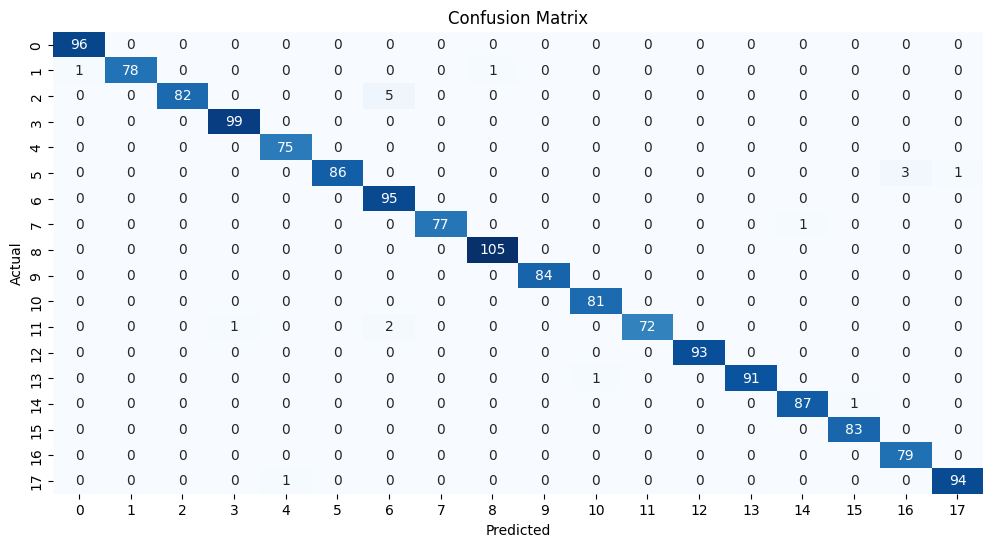

Classification Report:
----------------------
                    precision    recall  f1-score   support

        Apple_Bad     0.9897    1.0000    0.9948        96
        Guava_Bad     1.0000    0.9750    0.9873        80
       Apple_Good     1.0000    0.9425    0.9704        87
       Banana_Bad     0.9900    1.0000    0.9950        99
        Lime_Good     0.9868    1.0000    0.9934        75
       Orange_Bad     1.0000    0.9556    0.9773        90
      Banana_Good     0.9314    1.0000    0.9645        95
  Pomegranate_Bad     1.0000    0.9872    0.9935        78
      Guava_mixed     0.9906    1.0000    0.9953       105
      Apple_mixed     1.0000    1.0000    1.0000        84
      Lemon_mixed     0.9878    1.0000    0.9939        81
     Banana_mixed     1.0000    0.9600    0.9796        75
       Guava_Good     1.0000    1.0000    1.0000        93
         Lime_Bad     1.0000    0.9891    0.9945        92
 Pomegranate_Good     0.9886    0.9886    0.9886        88
Pomegran

In [ ]:
classes=list(train_set['labels'].unique())
print(classes)
# Put the model in evaluation mode
model.eval()

# Initialize lists to store true labels and predicted labels
y_true = []
y_pred = []

# Disable gradient computation for inference
with torch.no_grad():
    for inputs, labels in test_loader:  # Assuming you have defined the test DataLoader
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Get predicted labels
        _, predicted = torch.max(outputs, 1)

        # Append true labels and predicted labels to the lists
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate accuracy
accuracy = (np.array(y_true) == np.array(y_pred)).mean() * 100
print(f"Accuracy: {accuracy:.2f}%")

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Generate classification report
clr = classification_report(y_true, y_pred, target_names=classes, digits=4)
print("Classification Report:\n----------------------\n", clr)


In [ ]:
accuracy_RESTNET=accuracy
accuracy_RESTNET

98.85714285714286

### EFFICIENT NET MODEL

In [ ]:
class EfficientNetModel(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetModel, self).__init__()
        self.base_model = EfficientNet.from_pretrained('efficientnet-b5')
        self.base_model._fc = nn.Identity()  # Remove classification head
        self.bn = nn.BatchNorm1d(2048)
        self.fc1 = nn.Linear(2048, 1024)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(1024, 128)
        self.dropout2 = nn.Dropout(0.45)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.base_model(x)
        x = self.bn(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Initialize the model
EFF_model = EfficientNetModel(num_classes=len(unique_labels))
EFF_model

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth
100%|██████████| 117M/117M [00:01<00:00, 102MB/s] 


Loaded pretrained weights for efficientnet-b5


EfficientNetModel(
  (base_model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStatic

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_EFF = EFF_model.to(device)
#parameters
def count_parameters(model_EFF):
  return sum(p.numel() for p in model_EFF.parameters() if p.requires_grad)
print(f"The model has {count_parameters(model_EFF):,} trainable parameters.")
#Loss
criterion=nn.CrossEntropyLoss()
criterion=criterion.to(device)
l2_lambda = 0.016
l1_lambda = 0.006
#optim
optimizer = optim.Adamax(model_EFF.parameters(), lr=1e-4, weight_decay=l2_lambda)

The model has 30,576,578 trainable parameters.


In [ ]:
# Training
N_EPOCHS = 10
model_training_with_ask(N_EPOCHS, model_EFF, train_loader, val_loader, optimizer, criterion, device, 'lenet.pt')

Training will proceed until epoch 2 then you will be asked to
enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch [1/10], Train Loss: 2.6116, Train Accuracy: 0.3352, Val Loss: 2.1066, Val Accuracy: 0.7429

Continue training? (yes/no): yes
Epoch [2/10], Train Loss: 1.4843, Train Accuracy: 0.7287, Val Loss: 0.7741, Val Accuracy: 0.8610

Enter H to end training or an integer for the number of additional epochs to run then ask again
3
you entered 3 Training will continue to epoch 5

Continue training? (yes/no): yes
Epoch [3/10], Train Loss: 0.6797, Train Accuracy: 0.8581, Val Loss: 0.3505, Val Accuracy: 0.9467

Continue training? (yes/no): yes
Epoch [4/10], Train Loss: 0.3888, Train Accuracy: 0.9191, Val Loss: 0.1866, Val Accuracy: 0.9689

Continue training? (yes/no): yes
Epoch [5/10], Train Loss: 0.2609, Train Accuracy: 0.9484, Val Loss: 0.1404, Val Accuracy: 0.9746

Enter H to end training or an integer for the number of additional epoch

['Apple_Bad', 'Guava_Bad', 'Apple_Good', 'Banana_Bad', 'Lime_Good', 'Orange_Bad', 'Banana_Good', 'Pomegranate_Bad', 'Guava_mixed', 'Apple_mixed', 'Lemon_mixed', 'Banana_mixed', 'Guava_Good', 'Lime_Bad', 'Pomegranate_Good', 'Pomegranate_mixed', 'Orange_mixed', 'Orange_Good']
Accuracy: 98.22%


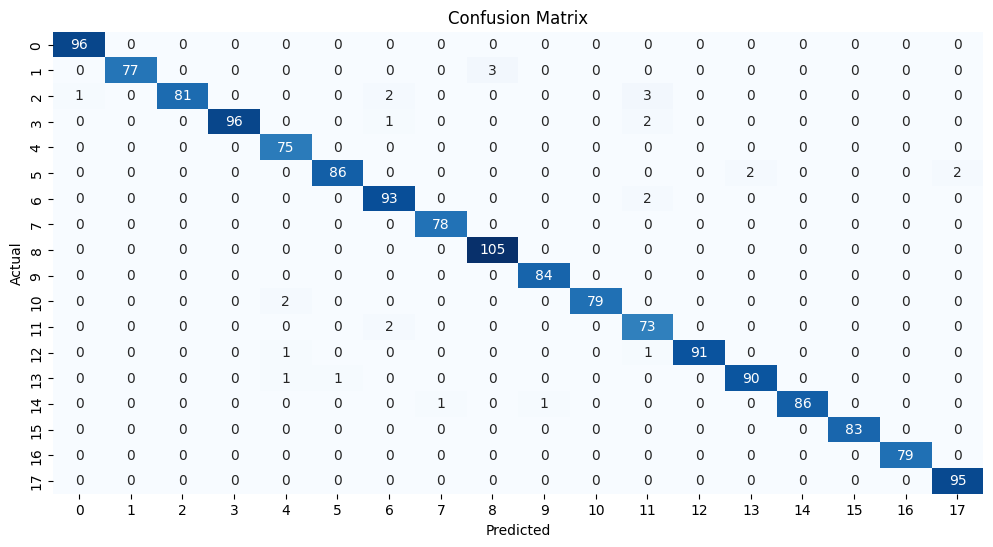

Classification Report:
----------------------
                    precision    recall  f1-score   support

        Apple_Bad     0.9897    1.0000    0.9948        96
        Guava_Bad     1.0000    0.9625    0.9809        80
       Apple_Good     1.0000    0.9310    0.9643        87
       Banana_Bad     1.0000    0.9697    0.9846        99
        Lime_Good     0.9494    1.0000    0.9740        75
       Orange_Bad     0.9885    0.9556    0.9718        90
      Banana_Good     0.9490    0.9789    0.9637        95
  Pomegranate_Bad     0.9873    1.0000    0.9936        78
      Guava_mixed     0.9722    1.0000    0.9859       105
      Apple_mixed     0.9882    1.0000    0.9941        84
      Lemon_mixed     1.0000    0.9753    0.9875        81
     Banana_mixed     0.9012    0.9733    0.9359        75
       Guava_Good     1.0000    0.9785    0.9891        93
         Lime_Bad     0.9783    0.9783    0.9783        92
 Pomegranate_Good     1.0000    0.9773    0.9885        88
Pomegran

In [ ]:
classes=list(train_set['labels'].unique())
print(classes)
# Put the model in evaluation mode
model_EFF.eval()

# Initialize lists to store true labels and predicted labels
y_true = []
y_pred = []

# Disable gradient computation for inference
with torch.no_grad():
    for inputs, labels in test_loader:  # Assuming you have defined the test DataLoader
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model_EFF(inputs)

        # Get predicted labels
        _, predicted = torch.max(outputs, 1)

        # Append true labels and predicted labels to the lists
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate accuracy
accuracy = (np.array(y_true) == np.array(y_pred)).mean() * 100
print(f"Accuracy: {accuracy:.2f}%")

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Generate classification report
clr = classification_report(y_true, y_pred, target_names=classes, digits=4)
print("Classification Report:\n----------------------\n", clr)


In [ ]:
accuracy_EFF=accuracy
accuracy_EFF

98.22222222222223

### KNOWLEDGE DISTILLATION:

In [ ]:
model_student=model_CNN.to(device)

In [ ]:
def test(model, test_loader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    #print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [ ]:
def train_knowledge_distillation(teacher, student, train_loader, epochs, learning_rate, T, soft_target_loss_weight, ce_loss_weight, device):
    ce_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass with the teacher model - do not save gradients here as we do not change the teacher's weights
            with torch.no_grad():
                teacher_logits = teacher(inputs)

            # Forward pass with the student model
            student_logits = student(inputs)

            #Soften the student logits by applying softmax first and log() second
            soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

            # Calculate the soft targets loss. Scaled by T**2 as suggested by the authors of the paper "Distilling the knowledge in a neural network"
            soft_targets_loss = -torch.sum(soft_targets * soft_prob) / soft_prob.size()[0] * (T**2)

            # Calculate the true label loss
            label_loss = ce_loss(student_logits, labels)

            # Weighted sum of the two losses
            loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

# Apply ``train_knowledge_distillation`` with a temperature of 2. Arbitrarily set the weights to 0.75 for CE and 0.25 for distillation loss.
train_knowledge_distillation(teacher=model, student=model_student, train_loader=train_loader, epochs=10, learning_rate=0.0001, T=2, soft_target_loss_weight=0.25, ce_loss_weight=0.75, device=device)
test_accuracy_light_ce_and_kd = test(model_student, test_loader, device)

# Compare the student test accuracy with and without the teacher, after distillation
print(f"Teacher accuracy: {accuracy_RESTNET:.2f}%")
print(f"Student accuracy without teacher: {accuracy_CNN:.2f}%")
print(f"Student accuracy with CE + KD: {test_accuracy_light_ce_and_kd:.2f}%")

Epoch 1/10, Loss: 3.526276251005996
Epoch 2/10, Loss: 3.3355539613734178
Epoch 3/10, Loss: 3.19954598927107
Epoch 4/10, Loss: 3.0855584470300728
Epoch 5/10, Loss: 2.979230750453928
Epoch 6/10, Loss: 2.9181189510991663
Epoch 7/10, Loss: 2.861567158516639
Epoch 8/10, Loss: 2.7890222202884694
Epoch 9/10, Loss: 2.782102952237989
Epoch 10/10, Loss: 2.709346461165798
Teacher accuracy: 98.86%
Student accuracy without teacher: 46.29%
Student accuracy with CE + KD: 66.79%


Accuracy: 66.79%


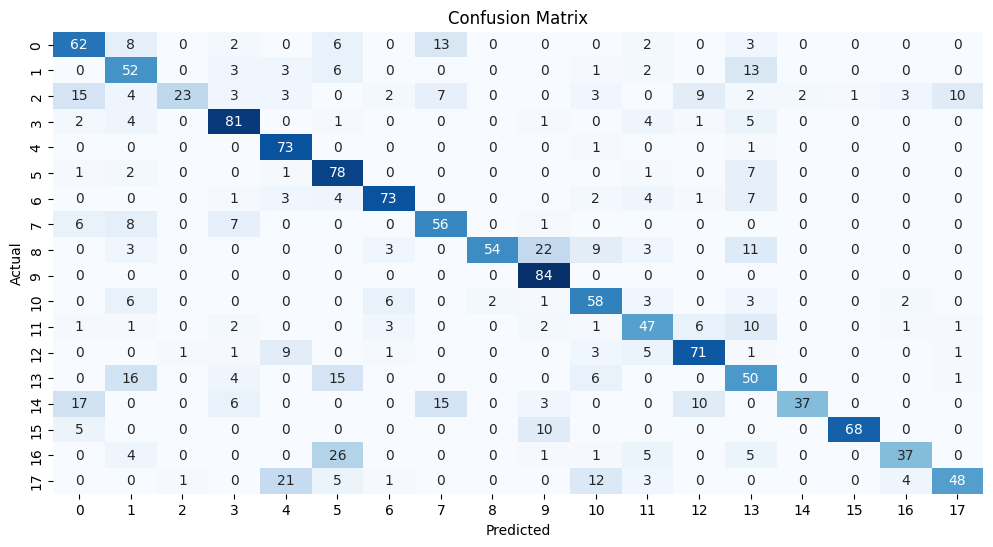

Classification Report:
----------------------
                    precision    recall  f1-score   support

        Apple_Bad     0.5688    0.6458    0.6049        96
        Guava_Bad     0.4815    0.6500    0.5532        80
       Apple_Good     0.9200    0.2644    0.4107        87
       Banana_Bad     0.7364    0.8182    0.7751        99
        Lime_Good     0.6460    0.9733    0.7766        75
       Orange_Bad     0.5532    0.8667    0.6753        90
      Banana_Good     0.8202    0.7684    0.7935        95
  Pomegranate_Bad     0.6154    0.7179    0.6627        78
      Guava_mixed     0.9643    0.5143    0.6708       105
      Apple_mixed     0.6720    1.0000    0.8038        84
      Lemon_mixed     0.5979    0.7160    0.6517        81
     Banana_mixed     0.5949    0.6267    0.6104        75
       Guava_Good     0.7245    0.7634    0.7435        93
         Lime_Bad     0.4237    0.5435    0.4762        92
 Pomegranate_Good     0.9487    0.4205    0.5827        88
Pomegran

In [ ]:
def evaluate_model(model, test_loader, device):
    model_student.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_student(inputs)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = (np.array(y_true) == np.array(y_pred)).mean() * 100
    print(f"Accuracy: {accuracy:.2f}%")

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(12, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)
    print("Classification Report:\n----------------------\n", clr)

# Apply ``train_knowledge_distillation`` with a temperature of 2. Arbitrarily set the weights to 0.75 for CE and 0.25 for distillation loss.
#train_knowledge_distillation(teacher=model, student=model_student, train_loader=train_loader, epochs=10, learning_rate=0.0001, T=2, soft_target_loss_weight=0.25, ce_loss_weight=0.75, device=device)

# Evaluate the student model after distillation
evaluate_model(model_student, test_loader, device)


In [ ]:
accuracy_KD=test_accuracy_light_ce_and_kd
accuracy_KD

66.7936507936508

## FINAL RESULT

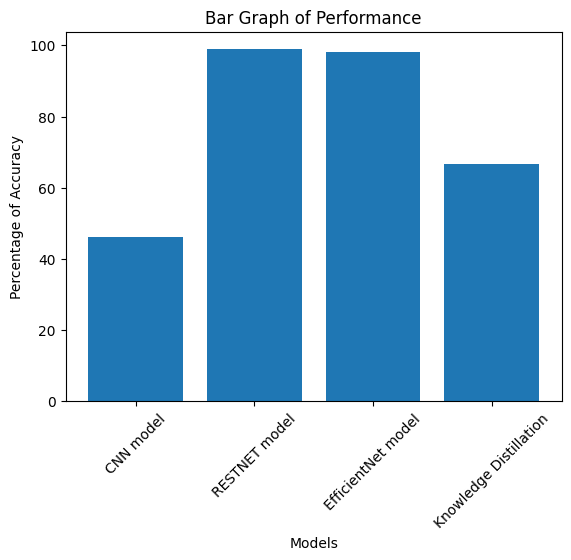

In [ ]:
result = [accuracy_CNN, accuracy_RESTNET, accuracy_EFF, accuracy_KD]
name = ['CNN model', 'RESTNET model', 'EfficientNet model', 'Knowledge Distillation']

plt.bar(name, result)
plt.xlabel('Models')
plt.ylabel('Percentage of Accuracy')
plt.title('Bar Graph of Performance')

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Display the plot
plt.show()


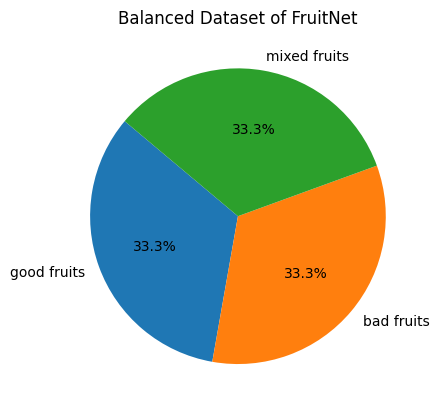

In [ ]:
ssg=[200,200,200]

# Data
ssg = [200, 200, 200]
labels = ['good fruits', 'bad fruits', 'mixed fruits']

# Plot pie chart
plt.pie(ssg, labels=labels, autopct='%1.1f%%', startangle=140)

# Add title
plt.title('Balanced Dataset of FruitNet')

# Display the plot
plt.show()


In [ ]:

'''def predict_image(model, image_path, device):
    # Preprocess the input image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Assuming input size required by the model is 224x224
        transforms.ToTensor(),
        # Add any other transformations required
    ])
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Evaluation mode
    model.eval()

    # Do not compute gradients
    with torch.no_grad():
        # Make prediction
        output = model(image)
        _, predicted_class = torch.max(output, 1)

    return predicted_class.item()

image_path = '/content/22693016-rotten-guava-fruit-isolated-on-white-background.jpg'
# Predict the class of the input image
predicted_class = predict_image(model, image_path, device)
print("Predicted class:", predicted_class)'''

FileNotFoundError: [Errno 2] No such file or directory: '/content/22693016-rotten-guava-fruit-isolated-on-white-background.jpg'